In [24]:
import cv2
import torch
import torch.nn as nn
import numpy as np
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
from PIL import Image
import torch.nn.functional as F


In [25]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()
        # Contracting Path (Encoder)
        self.enc1 = self.contract_block(3, 64)
        self.enc2 = self.contract_block(64, 128)
        self.enc3 = self.contract_block(128, 256)
        
        # Bottleneck
        self.bottleneck = self.contract_block(256, 512)
        
        # Expanding Path (Decoder)
        self.dec3 = self.expand_block(512 + 256, 256)
        self.dec2 = self.expand_block(256 + 128, 128)
        self.dec1 = self.expand_block(128 + 64, 64)
        
        # Final Output
        self.final = nn.Conv2d(64, 1, kernel_size=1)

    def contract_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

    def expand_block(self, in_channels, out_channels):
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)  # Dynamic upsampling
        )

    def forward(self, x):
        # Encoder
        enc1 = self.enc1(x)
        enc2 = self.enc2(enc1)
        enc3 = self.enc3(enc2)
        print(f"Enc1: {enc1.shape}, Enc2: {enc2.shape}, Enc3: {enc3.shape}")
        
        # Bottleneck
        bottleneck = self.bottleneck(enc3)
        print(f"Bottleneck: {bottleneck.shape}")
        
        # Resize bottleneck to match enc3
        bottleneck_upsampled = F.interpolate(bottleneck, size=enc3.shape[2:], mode='bilinear', align_corners=True)
        print(f"Bottleneck Upsampled: {bottleneck_upsampled.shape}")
        
        # Decoder
        dec3 = self.dec3(torch.cat((bottleneck_upsampled, enc3), dim=1))
        print(f"Dec3: {dec3.shape}")
        dec2 = self.dec2(torch.cat((dec3, enc2), dim=1))
        print(f"Dec2: {dec2.shape}")
        dec1 = self.dec1(torch.cat((dec2, enc1), dim=1))
        print(f"Dec1: {dec1.shape}")
        
        # Final layer
        out = self.final(dec1)
        print(f"Output: {out.shape}")
        return out



In [26]:
def crop_to_box_with_ruler_check_and_threshold(image, process_grayscale=False, min_ruler_area=1000):
    """
    Crop the image to a fixed inner box above the ruler. If no valid ruler is detected, return the original image.

    Args:
        image (numpy.ndarray): The input image (BGR or grayscale format).
        process_grayscale (bool): Flag indicating if the input is a grayscale image.
        min_ruler_area (int): Minimum area for a valid ruler contour.

    Returns:
        numpy.ndarray: The cropped image of the inner box, or the original image if no valid ruler is found.
    """
    # Handle grayscale separately
    if process_grayscale:
        original_image = image.copy()
        image = cv2.cvtColor(cv2.merge([image, image, image]), cv2.COLOR_BGR2GRAY)

    hsv_image = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)

    lower_yellow = np.array([20, 100, 100])
    upper_yellow = np.array([30, 255, 255])

    yellow_mask = cv2.inRange(hsv_image, lower_yellow, upper_yellow)

    contours, _ = cv2.findContours(yellow_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    ruler_bbox = None
    max_area = 0
    for contour in contours:
        x, y, w, h = cv2.boundingRect(contour)
        area = w * h
        if area > max_area and area > min_ruler_area:
            max_area = area
            ruler_bbox = (x, y, w, h)

    if ruler_bbox is None:
        return original_image if process_grayscale else image

    x_ruler, y_ruler, w_ruler, h_ruler = ruler_bbox
    margin_sides = 50
    box_height = 3 * h_ruler
    box_top = y_ruler - box_height
    box_bottom = y_ruler

    x_start = max(0, x_ruler - margin_sides)
    x_end = min(image.shape[1], x_ruler + w_ruler + margin_sides)
    y_start = max(0, box_top)
    y_end = min(image.shape[0], box_bottom)

    cropped = image[y_start:y_end, x_start:x_end]
    return cropped if not process_grayscale else cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)


In [27]:
from torchvision import transforms

# Transform for RGB images
# Adjusted image transformation
image_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224)),  # Resize correctly
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalize using ImageNet stats
])



# Transform for density maps (grayscale)
density_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((224, 224))  # Resize only
])



class BarnacleDataset(Dataset):
    def __init__(self, image_paths, mask_paths=None, image_transform=None, density_transform=None, target_count=100):
        if mask_paths is None or len(mask_paths) != len(image_paths):
            raise ValueError("Mask paths must be provided and match the number of images.")

        self.image_paths = image_paths
        self.mask_paths = mask_paths
        self.image_transform = image_transform
        self.density_transform = density_transform
        self.target_count = target_count


    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        # Debug: Image path
        print(f"Loading image from: {self.image_paths[idx]}")
        
        # Process image
        image = cv2.imread(self.image_paths[idx])
        if image is None:
            raise FileNotFoundError(f"Image file not found: {self.image_paths[idx]}")

        image = crop_to_box_with_ruler_check_and_threshold(image)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        pil_image = Image.fromarray(image)

        if self.image_transform:
            image = self.image_transform(pil_image)

        # Debug: Mask path
        if self.mask_paths:
            mask_path = self.mask_paths[idx]
            print(f"Loading mask from: {mask_path}")

            mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)
            if mask is None:
                raise FileNotFoundError(f"Mask file not found: {mask_path}")

            print(f"Loaded mask shape: {mask.shape}, dtype: {mask.dtype}")

            mask_3channel = cv2.merge([mask, mask, mask])
            mask_cropped = crop_to_box_with_ruler_check_and_threshold(mask_3channel)
            mask_cropped = cv2.cvtColor(mask_cropped, cv2.COLOR_BGR2GRAY)

            density_map = mask_cropped.astype(np.float32) / 255.0  # Normalize

            # Scale density map
            density_sum = density_map.sum()
            if density_sum > 0:
                density_map *= self.target_count / density_sum

            # Transform density map
            if self.density_transform:
                density_map = Image.fromarray((density_map * 255).astype(np.uint8))
                density_map = self.density_transform(density_map)

            return image, density_map


        raise ValueError("Mask paths must be provided for density map computation.")


In [28]:
def crop_and_resize_with_ruler(image, output_size=(224, 224)):
    """
    Crop the image based on the detected ruler and resize it to the target dimensions.
    If no ruler is detected, return the original image resized.

    Args:
        image (numpy.ndarray): Input image (BGR format).
        output_size (tuple): Target output dimensions (height, width).

    Returns:
        numpy.ndarray: Cropped and resized image.
    """
    # Perform the cropping using the ruler logic
    cropped_image = crop_to_box_with_ruler_check_and_threshold(image)

    # Resize the cropped region to the output size
    resized_image = cv2.resize(cropped_image, output_size, interpolation=cv2.INTER_LINEAR)

    return resized_image


In [29]:
# Define file paths
image_paths = ["img1.png", "img2.png"]
density_map_paths = ["mask1.png", "mask2.png"]

# Create dataset and dataloader
dataset = BarnacleDataset(
    image_paths=image_paths,
    mask_paths=density_map_paths,
    image_transform=image_transform,
    density_transform=density_transform
)

dataloader = DataLoader(dataset, batch_size=1, shuffle=True)

In [30]:
# Initialize U-Net model, loss function, and optimizer
model = UNet()
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

# Training loop
epochs = 8  # Adjust as needed
for epoch in range(epochs):
    model.train()
    total_loss = 0
    for images, density_maps in dataloader:
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, density_maps)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    print(f"Epoch {epoch + 1}/{epochs}, Loss: {total_loss / len(dataloader):.4f}")


Loading image from: img1.png
Loading mask from: mask1.png
Loaded mask shape: (2448, 3264), dtype: uint8
Enc1: torch.Size([1, 64, 112, 112]), Enc2: torch.Size([1, 128, 56, 56]), Enc3: torch.Size([1, 256, 28, 28])
Bottleneck: torch.Size([1, 512, 14, 14])
Bottleneck Upsampled: torch.Size([1, 512, 28, 28])
Dec3: torch.Size([1, 256, 56, 56])
Dec2: torch.Size([1, 128, 112, 112])
Dec1: torch.Size([1, 64, 224, 224])
Output: torch.Size([1, 1, 224, 224])
Loading image from: img2.png
Loading mask from: mask2.png
Loaded mask shape: (2448, 3264), dtype: uint8
Enc1: torch.Size([1, 64, 112, 112]), Enc2: torch.Size([1, 128, 56, 56]), Enc3: torch.Size([1, 256, 28, 28])
Bottleneck: torch.Size([1, 512, 14, 14])
Bottleneck Upsampled: torch.Size([1, 512, 28, 28])
Dec3: torch.Size([1, 256, 56, 56])
Dec2: torch.Size([1, 128, 112, 112])
Dec1: torch.Size([1, 64, 224, 224])
Output: torch.Size([1, 1, 224, 224])
Epoch 1/8, Loss: 0.0002
Loading image from: img1.png
Loading mask from: mask1.png
Loaded mask shape: (

libpng warning: iCCP: known incorrect sRGB profile


Enc1: torch.Size([1, 64, 112, 112]), Enc2: torch.Size([1, 128, 56, 56]), Enc3: torch.Size([1, 256, 28, 28])
Bottleneck: torch.Size([1, 512, 14, 14])
Bottleneck Upsampled: torch.Size([1, 512, 28, 28])
Dec3: torch.Size([1, 256, 56, 56])
Dec2: torch.Size([1, 128, 112, 112])
Dec1: torch.Size([1, 64, 224, 224])
Output: torch.Size([1, 1, 224, 224])
Predicted Barnacle Count: 86.87


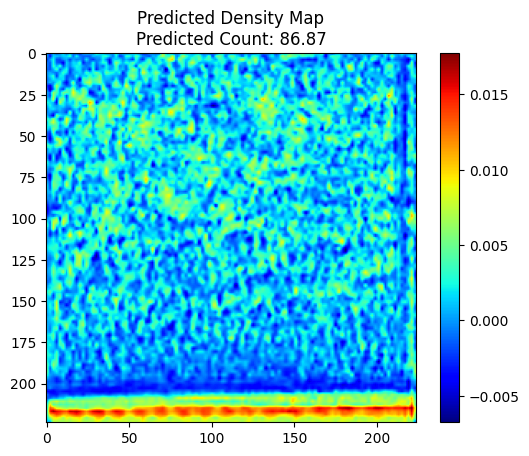

In [34]:
# Test the model on an unseen image
model.eval()
with torch.no_grad():
    unseen_image = cv2.imread("unseen_img1.png")
    unseen_image = crop_to_box_with_ruler_check_and_threshold(unseen_image)  # Apply cropping
    unseen_image = cv2.cvtColor(unseen_image, cv2.COLOR_BGR2RGB)
    pil_unseen_image = Image.fromarray(unseen_image)

    # Transform the image
    transformed_unseen_image = image_transform(pil_unseen_image).unsqueeze(0)  # Add batch dimension

    # Predict density map
    predicted_density_map = model(transformed_unseen_image).squeeze(0).squeeze(0).numpy()

    # Calculate total count
    predicted_count = predicted_density_map.sum()
    print(f"Predicted Barnacle Count: {predicted_count:.2f}")

    # Visualize the density map
    plt.imshow(predicted_density_map, cmap="jet")
    plt.colorbar()
    plt.title(f"Predicted Density Map\nPredicted Count: {predicted_count:.2f}")
    plt.show()
